# winddy

研究Loss线性加权对某一类标签的保护作用

In [1]:
import torch 
import numpy as np
import os
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from LeNet import LeNet
from torch.autograd import Variable
import sys
sys.path.append('./utils')
from myUtils import my_fgsm, my_imshow
%matplotlib inline

In [2]:
NORMALIZE = True
DEVICE = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [3]:
if NORMALIZE:
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
else:
    trans = transforms.Compose([
        transforms.ToTensor(),
    ])

In [4]:
data_home = '/data/winddy/'

train_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=False, download=True, transform=trans)

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

## 对每一类标签分别进行保护

In [32]:
#读取 model_adv模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [33]:
# 记录结果
results_infos = {}

# 先读取未经过对抗训练的模型
# 在进行对抗训练
if NORMALIZE:
    model_path = './model/LeNet_MNIST_Special_linear.pt'
else:
    model_path = './model/LeNet_MNIST_Special_linear_unNormalize.pt'

epsilon = 0.3
criterion = torch.nn.CrossEntropyLoss()
    
for i_label in range(10):
    
    # 读取预训练模型
    model_linear_adv = LeNet()
    model_linear_adv.load_state_dict(torch.load(model_path))
    model_linear_adv = model_linear_adv.to(DEVICE)
    model_linear_adv.train()
    
    optimizer = torch.optim.SGD(params=model_linear_adv.parameters(), lr=0.01, momentum=0.5)
    loss_F = torch.nn.functional.cross_entropy
    
    weights_linear = torch.Tensor([1.0,1.0,1.0,1.0,1.0,
                              1.0,1.0,1.0,1.0,1.0])
    weights_linear[i_label] = 5.0
    weights_linear = weights_linear.to(DEVICE)
    LABEL = 'Protect Label ' + str(i_label)
    print('weights_linear: {}'.format(weights_linear))
    
    # 开始训练
    for epoch in range(10):
        count = 0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
    
            optimizer.zero_grad()
            output = model_linear_adv(data)
            loss = loss_F(output, target, weight=weights_linear)
            
            loss.backward()
            optimizer.step()
            
            count += len(data)
            print('\r {}|{}'.format(count, len(train_loader.dataset)), end='')
            
        # 测试
        correct = 0
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model_linear_adv(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        print('epoch: {}, test correct: {}'.format(epoch,correct/len(test_loader.dataset)))
        
    ## 训练结束
    
    # 比较结果
    
    ## 对 model_linear_adv的评估
    print('对 model_linear_adv的评估')
    results_info = {}
    model_linear_adv.eval()
    images_targets = {}
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
            output = model_linear_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[1] = images_targets
    
    ## 对 model_adv 的评估
    print('对 model_adv 的评估')
    model_adv.eval()
    images_targets = {}
    
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_adv, criterion, epsilon, DEVICE)
            output = model_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[2] = images_targets
    
    # 记录结果
    results_infos[i_label] = results_info

weights_linear: tensor([5., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9837
 60000|60000epoch: 1, test correct: 0.9849
 60000|60000epoch: 2, test correct: 0.9862
 60000|60000epoch: 3, test correct: 0.9862
 60000|60000epoch: 4, test correct: 0.9875
 60000|60000epoch: 5, test correct: 0.9876
 60000|60000epoch: 6, test correct: 0.9866
 60000|60000epoch: 7, test correct: 0.9891
 60000|60000epoch: 8, test correct: 0.9872
 60000|60000epoch: 9, test correct: 0.9895
 980
 0 correct: 0.9938775510204082
 1135
 1 correct: 0.9770925110132158
 1032
 2 correct: 0.9631782945736435
 1010
 3 correct: 0.9316831683168317
 982
 4 correct: 0.9317718940936863
 892
 5 correct: 0.9417040358744395
 958
 6 correct: 0.9405010438413361
 1028
 7 correct: 0.9494163424124513
 974
 8 correct: 0.8829568788501027
 1009
 9 correct: 0.9207135777998018
 980
 0 correct: 0.9836734693877551
 1135
 1 correct: 0.9823788546255506
 1032
 2 correct: 0.9651162790697675
 1010
 3 corr

 1028
 7 correct: 0.9464980544747081
 974
 8 correct: 0.944558521560575
 1009
 9 correct: 0.9137760158572844
 980
 0 correct: 0.9836734693877551
 1135
 1 correct: 0.9823788546255506
 1032
 2 correct: 0.9651162790697675
 1010
 3 correct: 0.9198019801980198
 982
 4 correct: 0.9317718940936863
 892
 5 correct: 0.9394618834080718
 958
 6 correct: 0.9728601252609603
 1028
 7 correct: 0.9503891050583657
 974
 8 correct: 0.9342915811088296
 1009
 9 correct: 0.9375619425173439
weights_linear: tensor([1., 1., 1., 1., 1., 1., 1., 5., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9831
 60000|60000epoch: 1, test correct: 0.9829
 60000|60000epoch: 2, test correct: 0.9841
 60000|60000epoch: 3, test correct: 0.9882
 60000|60000epoch: 4, test correct: 0.986
 60000|60000epoch: 5, test correct: 0.9869
 60000|60000epoch: 6, test correct: 0.9868
 60000|60000epoch: 7, test correct: 0.9879
 60000|60000epoch: 8, test correct: 0.9897
 60000|60000epoch: 9, test correct: 0.989
 980
 0 correct:

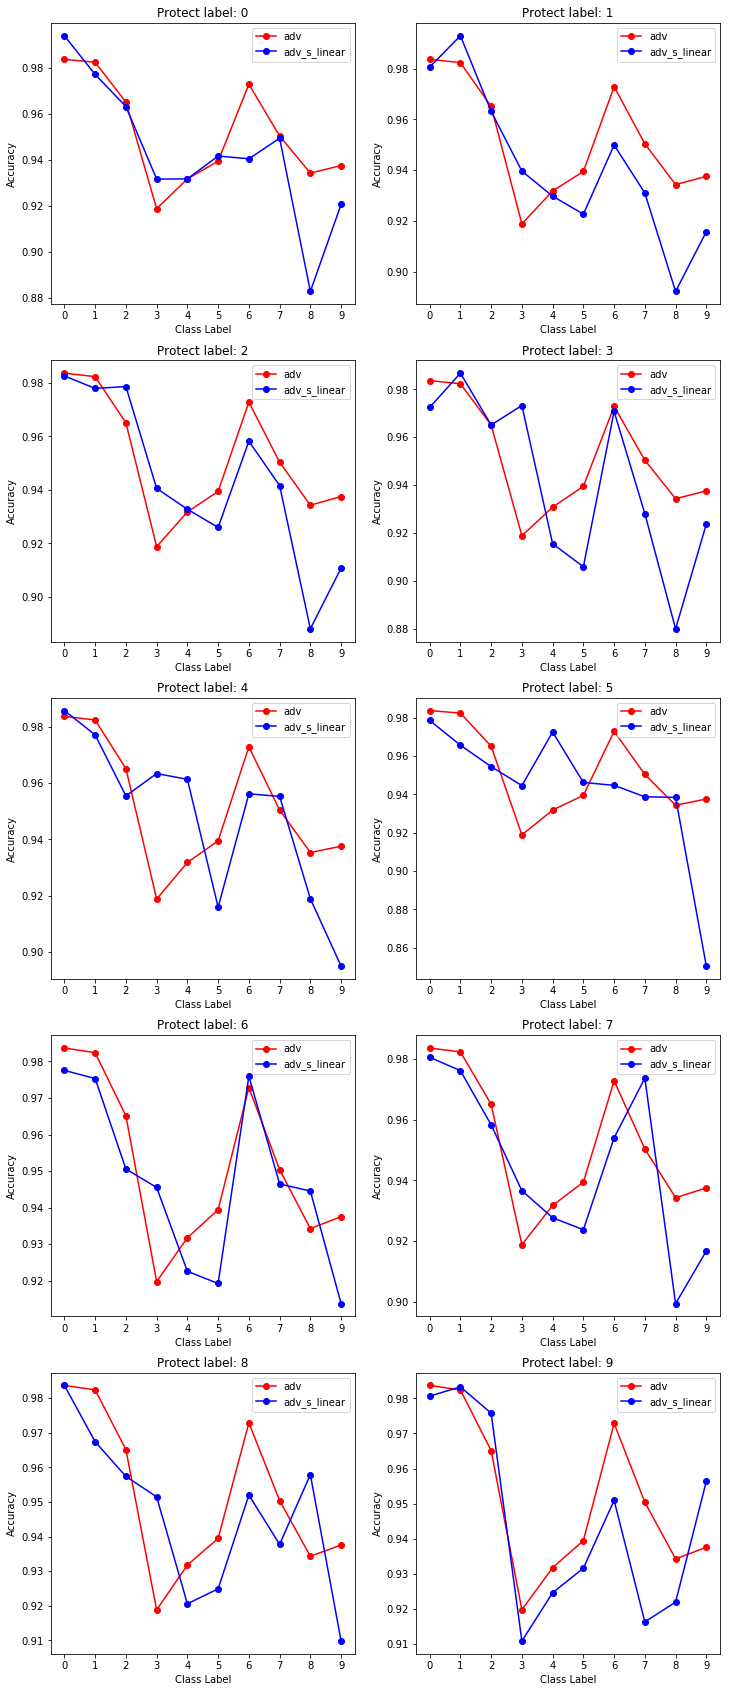

In [52]:
x = [0,1,2,3,4,5,6,7,8,9]
nrows = 5
ncols = 2
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.figure(figsize=(6 * ncols, 6 * nrows))
count = 1

for i in results_infos.keys():
    tmp = results_infos[i]
    
    tmp_s_adv = tmp[1]
    tmp_adv = tmp[2]
    tmp_s_arr = []
    tmp_arr = []
    for key_tmp in tmp_s_adv.keys():
        
        tmp_s_arr.append(tmp_s_adv[key_tmp][1])
        tmp_arr.append(tmp_adv[key_tmp][1])
    
    plt.subplot(nrows, ncols, count)
    plt.plot(x, tmp_arr, 'ro-', label='adv')
    plt.plot(x, tmp_s_arr, 'bo-', label='adv_s_linear')
    plt.xticks(x)
    plt.title('Protect label: '+str(i))
    plt.legend(loc="upper right")
    plt.xlabel('Class Label')
    plt.ylabel('Accuracy')
    count += 1

## 对每一类标签迭代进行保护

In [6]:
#读取 model_adv模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [7]:
# 记录结果
results_infos = {}

# 先读取未经过对抗训练的模型
# 在进行对抗训练
if NORMALIZE:
    model_path = './model/LeNet_MNIST_Special_linear.pt'
else:
    model_path = './model/LeNet_MNIST_Special_linear_unNormalize.pt'

# 读取预训练模型
model_linear_adv = LeNet()
model_linear_adv.load_state_dict(torch.load(model_path))
model_linear_adv = model_linear_adv.to(DEVICE)
model_linear_adv.train()

optimizer = torch.optim.SGD(params=model_linear_adv.parameters(), lr=0.01, momentum=0.5)
loss_F = torch.nn.functional.cross_entropy
    
epsilon = 0.3
criterion = torch.nn.CrossEntropyLoss()
    
for i_label in range(10):    
    weights_linear = torch.Tensor([1.0,1.0,1.0,1.0,1.0,
                              1.0,1.0,1.0,1.0,1.0])
    weights_linear[i_label] = 5.0
    weights_linear = weights_linear.to(DEVICE)
    LABEL = 'Protect Label ' + str(i_label)
    print('weights_linear: {}'.format(weights_linear))
    
    # 开始训练
    for epoch in range(10):
        count = 0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
    
            optimizer.zero_grad()
            output = model_linear_adv(data)
            loss = loss_F(output, target, weight=weights_linear)
            
            loss.backward()
            optimizer.step()
            
            count += len(data)
            print('\r {}|{}'.format(count, len(train_loader.dataset)), end='')
            
        # 测试
        correct = 0
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model_linear_adv(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        print('epoch: {}, test correct: {}'.format(epoch,correct/len(test_loader.dataset)))
        
    ## 训练结束
    
    # 比较结果
    
    ## 对 model_linear_adv的评估
    print('对 model_linear_adv的评估')
    results_info = {}
    model_linear_adv.eval()
    images_targets = {}
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
            output = model_linear_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[1] = images_targets
    
    ## 对 model_adv 的评估
    print('对 model_adv 的评估')
    model_adv.eval()
    images_targets = {}
    
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_adv, criterion, epsilon, DEVICE)
            output = model_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[2] = images_targets
    
    # 记录结果
    results_infos[i_label] = results_info

weights_linear: tensor([5., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9823
 60000|60000epoch: 1, test correct: 0.984
 60000|60000epoch: 2, test correct: 0.9861
 60000|60000epoch: 3, test correct: 0.9868
 60000|60000epoch: 4, test correct: 0.988
 60000|60000epoch: 5, test correct: 0.9871
 60000|60000epoch: 6, test correct: 0.9883
 60000|60000epoch: 7, test correct: 0.9882
 60000|60000epoch: 8, test correct: 0.9886
 60000|60000epoch: 9, test correct: 0.9872
对 model_linear_adv的评估
 980
 0 correct: 0.9948979591836735
 1135
 1 correct: 0.9770925110132158
 1032
 2 correct: 0.9612403100775194
 1010
 3 correct: 0.9099009900990099
 982
 4 correct: 0.8991853360488798
 892
 5 correct: 0.9394618834080718
 958
 6 correct: 0.9446764091858038
 1028
 7 correct: 0.9221789883268483
 974
 8 correct: 0.9014373716632443
 1009
 9 correct: 0.9494549058473737
对 model_adv 的评估
 980
 0 correct: 0.9836734693877551
 1135
 1 correct: 0.9823788546255506
 1032
 2 corre

 980
 0 correct: 0.986734693877551
 1135
 1 correct: 0.9779735682819384
 1032
 2 correct: 0.9680232558139535
 1010
 3 correct: 0.9574257425742574
 982
 4 correct: 0.9572301425661914
 892
 5 correct: 0.9405829596412556
 958
 6 correct: 0.9728601252609603
 1028
 7 correct: 0.9542801556420234
 974
 8 correct: 0.9414784394250514
 1009
 9 correct: 0.9355797819623389
对 model_adv 的评估
 980
 0 correct: 0.9836734693877551
 1135
 1 correct: 0.9823788546255506
 1032
 2 correct: 0.9651162790697675
 1010
 3 correct: 0.9188118811881189
 982
 4 correct: 0.9317718940936863
 892
 5 correct: 0.9394618834080718
 958
 6 correct: 0.9728601252609603
 1028
 7 correct: 0.9503891050583657
 974
 8 correct: 0.9342915811088296
 1009
 9 correct: 0.9375619425173439
weights_linear: tensor([1., 1., 1., 1., 1., 1., 1., 5., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9914
 60000|60000epoch: 1, test correct: 0.9913
 60000|60000epoch: 2, test correct: 0.9923
 60000|60000epoch: 3, test correct: 0.9913
 

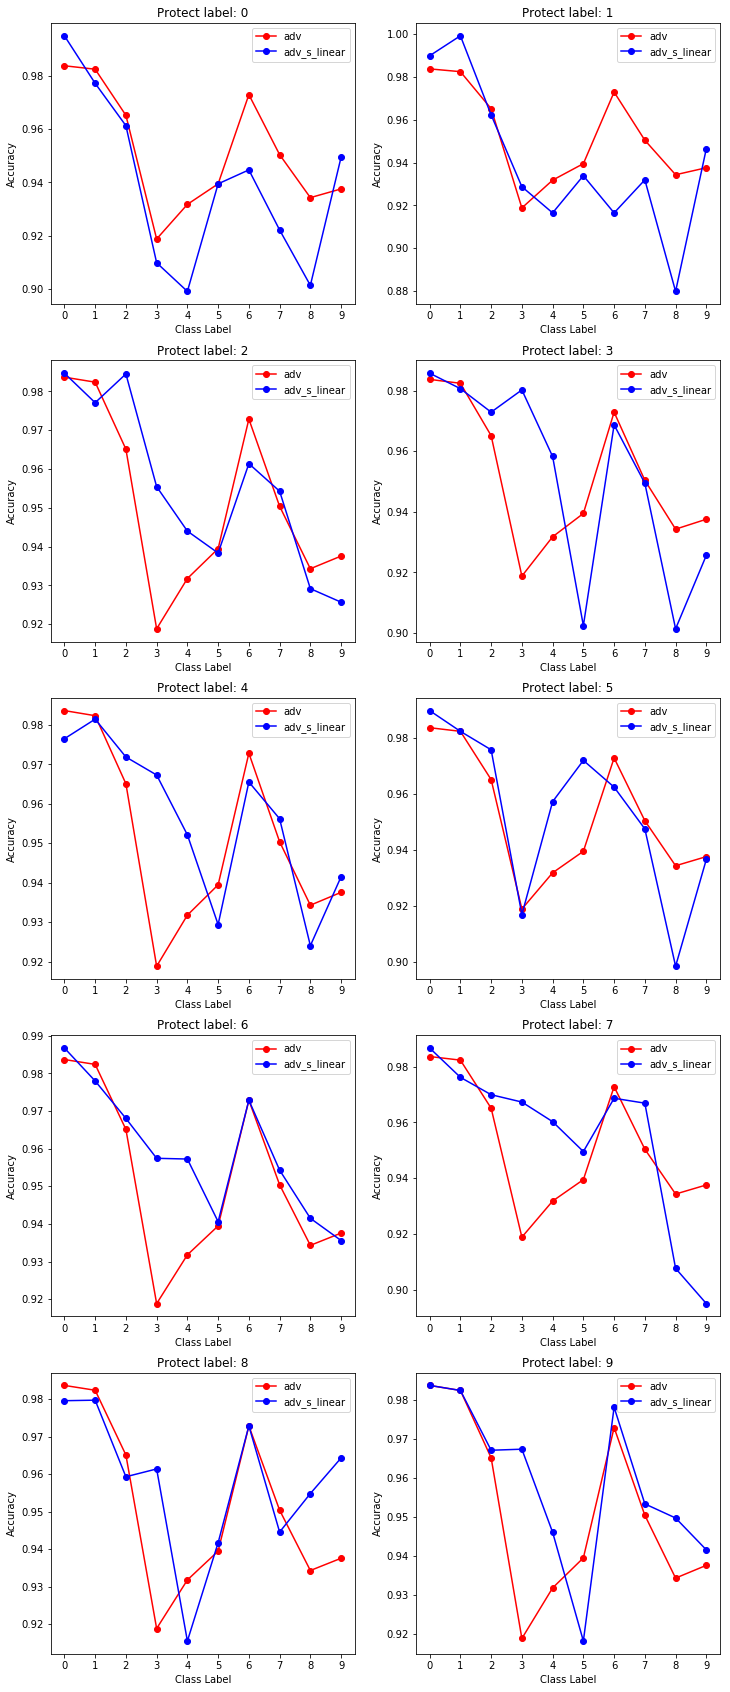

In [8]:
x = [0,1,2,3,4,5,6,7,8,9]
nrows = 5
ncols = 2
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.figure(figsize=(6 * ncols, 6 * nrows))
count = 1

for i in results_infos.keys():
    tmp = results_infos[i]
    
    tmp_s_adv = tmp[1]
    tmp_adv = tmp[2]
    tmp_s_arr = []
    tmp_arr = []
    for key_tmp in tmp_s_adv.keys():
        
        tmp_s_arr.append(tmp_s_adv[key_tmp][1])
        tmp_arr.append(tmp_adv[key_tmp][1])
    
    plt.subplot(nrows, ncols, count)
    plt.plot(x, tmp_arr, 'ro-', label='adv')
    plt.plot(x, tmp_s_arr, 'bo-', label='adv_s_linear')
    plt.xticks(x)
    plt.title('Protect label: '+str(i))
    plt.legend(loc="upper right")
    plt.xlabel('Class Label')
    plt.ylabel('Accuracy')
    count += 1